## M161 first question notebook, Knn with jaccard distance classifier
## Data preprocessing
### Data cleaning I
 1. check types 
 2. check for null values
 3. check duplicates
 4. keeping 10000 instances to reduce computation load

In [1]:
import pandas as pd
file_path = 'bigdata2025classification/train.csv'

def load_and_process_data(file_path):
    # Load data from a CSV file
    dataTrain = pd.read_csv(file_path)

    print("Data loaded successfully.")
    print("First 5 rows of the dataset:")
    print(dataTrain.head())

    print("\nData summary:")
    print(dataTrain.info())

    # Check for missing values in the dataframe
    print("\nMissing values in each column:")
    print(dataTrain.isnull().sum())
    
    return dataTrain

dataTrain = load_and_process_data(file_path)

# check column data types
def check_column_types(dataTrain):
    print("\nColumn data types:")
    print(dataTrain.dtypes)

check_column_types(dataTrain)





Data loaded successfully.
First 5 rows of the dataset:
       Id                                              Title  \
0  227464  Netflix is coming to cable boxes, and Amazon i...   
1  244074  Pharrell, Iranian President React to Tehran 'H...   
2   60707                    Wildlife service seeks comments   
3   27883  Facebook teams up with Storyful to launch 'FB ...   
4  169596           Caesars plans US$880 mln New York casino   

                                             Content          Label  
0   if you subscribe to one of three rinky-dink (...  Entertainment  
1   pharrell, iranian president react to tehran '...  Entertainment  
2   the u.s. fish and wildlife service has reopen...     Technology  
3   the very nature of social media means it is o...     Technology  
4   caesars plans us$880 mln new york casino jul ...       Business  

Data summary:
<class 'pandas.DataFrame'>
RangeIndex: 111795 entries, 0 to 111794
Data columns (total 4 columns):
 #   Column   Non-Null Cou

In [2]:
# Stratify and keep 3000 instances based on the 'Label' column
from sklearn.model_selection import train_test_split

# Stratify and sample 3000 instances
stratified_data, _ = train_test_split(
    dataTrain,
    train_size=3000,
    stratify=dataTrain['Label'],
    random_state=42
)
dataTrain = stratified_data.reset_index(drop=True)
print(f"Subset shape (stratified): {dataTrain.shape}")

Subset shape (stratified): (3000, 4)


Label
Entertainment    1203
Technology        808
Business          666
Health            323
Name: count, dtype: int64

Number of unique Labels: 4


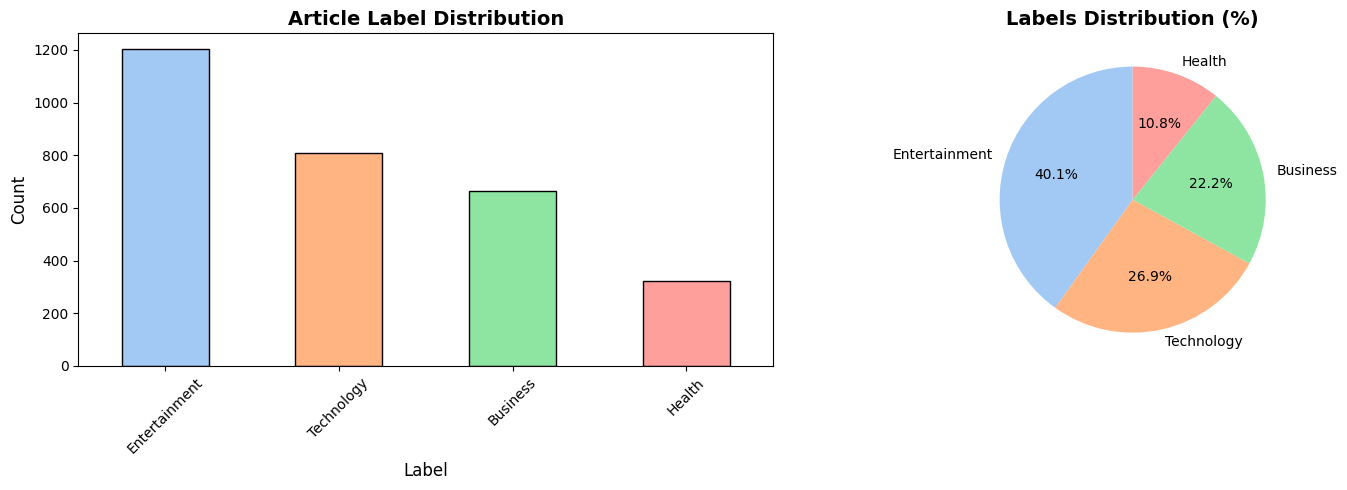

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
category_counts = dataTrain['Label'].value_counts()

print(category_counts)
print(f"\nNumber of unique Labels: {dataTrain['Label'].nunique()}")

# Get a color palette with as many colors as there are categories
palette = sns.color_palette('pastel', n_colors=len(category_counts))

# Bar plot with consistent colors
category_counts.plot(kind='bar', ax=axes[0], color=palette, edgecolor='black')
axes[0].set_title('Article Label Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Pie chart with the same colors
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
            startangle=90, colors=palette)
axes[1].set_title('Labels Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Data cleaning II continue
3. check for duplicates
***************************
### note
- the data types of all exeprt Id column is "object" in pandas, it works, but could be converted to String for a performance uplift.
*****************************

In [4]:
# Check for duplicate rows in the dataframe
def check_duplicates(dataTrain):
    duplicate_count = dataTrain.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicate_count}")
    return duplicate_count

check_duplicates(dataTrain)

# Check for duplicates based only on 'Title' column
def check_title_duplicates(dataTrain):
    if 'Title' in dataTrain.columns:
        dup_count = dataTrain.duplicated(subset=['Title']).sum()
        print(f"\nNumber of duplicate rows based on Title: {dup_count}")
        return dup_count
    else:
        print("'Title' column not found in the dataframe.")
        return None

check_title_duplicates(dataTrain)

# Check for duplicates based only on 'Content' column
def check_content_duplicates(dataTrain):
    if 'Content' in dataTrain.columns:
        dup_count = dataTrain.duplicated(subset=['Content']).sum()
        print(f"\nNumber of duplicate rows based on Content: {dup_count}")
        return dup_count
    else:
        print("'Content' column not found in the dataframe.")
        return None

check_content_duplicates(dataTrain)
# Check for duplicates based on 'Title' and 'Content' columns
def check_title_content_duplicates(dataTrain):
    if 'Title' in dataTrain.columns and 'Content' in dataTrain.columns:
        dup_count = dataTrain.duplicated(subset=['Title', 'Content']).sum()
        print(f"\nNumber of duplicate rows based on Title and Content: {dup_count}")
        return dup_count
    else:
        print("'Title' and/or 'Content' columns not found in the dataframe.")
        return None

check_title_content_duplicates(dataTrain)


Number of duplicate rows: 0

Number of duplicate rows based on Title: 0

Number of duplicate rows based on Content: 10

Number of duplicate rows based on Title and Content: 0


np.int64(0)

In [5]:
# Remove duplicates based on 'Title' and 'Content' columns, keeping the first occurrence
dataTrain = dataTrain.drop_duplicates(subset=['Title', 'Content'], keep='first')
print("\nDuplicates based on Title and Content removed. Data shape:", dataTrain.shape)


# Reset the index after removing duplicates
dataTrain = dataTrain.reset_index(drop=True)
print("\nIndex reset. Data shape:", dataTrain.shape)
dataTrain.info()


Duplicates based on Title and Content removed. Data shape: (3000, 4)

Index reset. Data shape: (3000, 4)
<class 'pandas.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Id       3000 non-null   int64
 1   Title    3000 non-null   str  
 2   Content  3000 non-null   str  
 3   Label    3000 non-null   str  
dtypes: int64(1), str(3)
memory usage: 93.9 KB



### Remove words not in English dictionary

- **probably could change dictionary for better results but it works...**


In [6]:
import re
import nltk
from nltk.corpus import words

# Download the words corpus if not already present
nltk.download('words')
english_words = set(words.words())

def clean_text(text):
    # Split text into words
    word_list = re.findall(r'\b\w+\b', str(text))
    cleaned_words = []
    for word in word_list:
        # Drop any word not in dictionary
        if word.lower() not in english_words:
            continue
        # Drop words with 2+ repeating chars not in dictionary (redundant now, but kept for clarity)
        if re.search(r'(.)\1{1,}', word):
            if word.lower() not in english_words:
                continue
        cleaned_words.append(word)
    return ' '.join(cleaned_words)

# Apply to both columns
dataTrain['Title'] = dataTrain['Title'].apply(clean_text)
dataTrain['Content'] = dataTrain['Content'].apply(clean_text)


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\odys_\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Text clean up 
1. Expand contractions
2. Convert to lowercase
3. Remove special characters (keep only letters and spaces)
4. Remove extra spaces
5. Remove stopwords, lemmatize, and stem

**warning**
- takes up considerable time to execute

In [7]:
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Download required NLTK data if not already present
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text):
    # Expand contractions
    text = contractions.fix(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    words = text.split()
    # Remove stopwords, lemmatize, and stem
    words = [stemmer.stem(lemmatizer.lemmatize(word)) for word in words if word not in stop_words]
    text = ' '.join(words)
    return text

for col in ['Title', 'Content']:
    dataTrain[col] = dataTrain[col].astype(str).apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\odys_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\odys_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\odys_\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Just printing out the firtst 5 columns to see what happend to text

In [8]:
print(dataTrain.head())

       Id                                              Title  \
0  281834                       show sex tape la premier one   
1  174054                            dollar ahead fed releas   
2  276901  watch german airport becom home epic star epis...   
3   50217                    galaxi note confirm inch screen   
4  166601                                     nobl split two   

                                             Content          Label  
0  asham sex tape film night premier l regenc vil...  Entertainment  
1  greenback bought yen afternoon littl yen bough...       Business  
2  watch german airport becom home epic star epis...  Entertainment  
3  next pen power due announc instead pen peopl i...     Technology  
4                nobl smaller loss separ nook medium       Business  


## Starting future extraction (converting text to numbers for ML algorythms to run)
- we should use **Bag of words** based on project requirements 
- Shoud take into account the title column in combination with content ()

### ℹ️info 

- countvetrorizer does convert everyting to lowecase and removes punctuation by default. could remove steps from above Nltk powered code cell
- Title and Content column are combined in to a sing string and then tokenized and vectorized

In [9]:
# Combine 'Title' and 'Content' columns into a single string
# and vectorize the result for classification
from sklearn.feature_extraction.text import CountVectorizer

# Create a new column that combines Title and Content
# (if either column is missing, fill with empty string)
dataTrain['Combined'] = dataTrain['Title'].fillna('') + ' ' + dataTrain['Content'].fillna('')

# Initialize CountVectorizer (Bag of Words)
bow_vectorizer = CountVectorizer(binary=True, max_features=5000)  # Use binary=True for presence/absence of words, limit to top 5000 features

# Fit and transform the combined column
dataTrain_bow = bow_vectorizer.fit_transform(dataTrain['Combined'])

# Show shape and a sample
print('Bag of Words matrix shape:', dataTrain_bow.shape)
print("dataTrain_bow sample (first 10 rows):", dataTrain_bow[:10].toarray())
print('Feature names (first 20):', bow_vectorizer.get_feature_names_out()[:20])

Bag of Words matrix shape: (3000, 5000)
dataTrain_bow sample (first 10 rows): [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Feature names (first 20): ['aa' 'abandon' 'abbey' 'abid' 'abil' 'abl' 'abnorm' 'aboard' 'abort'
 'abroad' 'abrupt' 'abruptli' 'absenc' 'absent' 'absolut' 'absorb'
 'abstract' 'absurd' 'abu' 'abund']


### visual check for weird words, repetitions, etc...
- remember stemming and lemmatization was executed on text

In [10]:
print('Feature names (first 100):', bow_vectorizer.get_feature_names_out()[:1000])

Feature names (first 100): ['aa' 'abandon' 'abbey' 'abid' 'abil' 'abl' 'abnorm' 'aboard' 'abort'
 'abroad' 'abrupt' 'abruptli' 'absenc' 'absent' 'absolut' 'absorb'
 'abstract' 'absurd' 'abu' 'abund' 'abus' 'academ' 'academi' 'acceler'
 'accent' 'accept' 'access' 'accessori' 'accid' 'accident' 'acclaim'
 'accommod' 'accompani' 'accomplish' 'accord' 'accordingli' 'account'
 'accret' 'accumul' 'accur' 'accuraci' 'accus' 'ace' 'achiev' 'acid'
 'acknowledg' 'acoust' 'acquir' 'acquisit' 'acr' 'across' 'act' 'action'
 'activ' 'activist' 'actor' 'actress' 'actual' 'acut' 'ad' 'adapt' 'add'
 'addict' 'addit' 'address' 'adequ' 'adjac' 'adjust' 'administr' 'admir'
 'admiss' 'admit' 'adolesc' 'adopt' 'ador' 'adult' 'adulthood' 'advanc'
 'advantag' 'adventur' 'advers' 'advertis' 'advic' 'advis' 'advisor'
 'advisori' 'advoc' 'advocaci' 'aerial' 'aesthet' 'affair' 'affect'
 'affili' 'affirm' 'affluent' 'afford' 'afraid' 'aftermath' 'afternoon'
 'afterward' 'age' 'agenc' 'agenda' 'agent' 'aggress' 'ag

## KNN with jaccard distance classifier

In [ ]:
# KNN classification with Jaccard distance and 5-fold cross-validation on Bag of Words features
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import jaccard_score, make_scorer
import numpy as np


# Use the same Bag of Words features as before
X = dataTrain_bow.toarray()
y = dataTrain['Label'].values

# Initialize KNN classifier with Jaccard distance (metric='jaccard')
knn_clf = KNeighborsClassifier(n_neighbors=5, metric='jaccard', n_jobs=6)

# Perform 5-fold cross-validation using accuracy
cv_scores_acc = cross_val_score(knn_clf, X, y, cv=5, scoring='accuracy', n_jobs=6)
print('KNN (Jaccard) 5-fold CV accuracy scores:', cv_scores_acc)
print('Mean CV accuracy:', np.mean(cv_scores_acc))



KNN (Jaccard) 5-fold CV accuracy scores: [0.85833333 0.91166667 0.88166667 0.87833333 0.88166667]
Mean CV accuracy: 0.8823333333333334
